In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

## The R2D2 prior

Suppose we have a normal regression model:

$$
\begin{aligned}
Y_i &\sim \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= \alpha + \beta_1 X_{1i} + \beta_2 X_{2i} + \dots + \beta_p X_{pi} = \alpha + \boldsymbol{X}\boldsymbol{\beta}
\end{aligned}
$$

where $\boldsymbol{X}$ is the $n \times p$ design matrix (without the intercept) and $\boldsymbol{\beta}$, of length $p$, is the vector of coefficients.

The R2D2 prior model is:

$$
\begin{aligned}
\beta_j &\sim \text{Normal}(0, \phi_j W \sigma^2) \\
\boldsymbol{\phi} &\sim \text{Dirichlet}(\xi_1, \dots, \xi_p) \\
W & = \frac{R^2}{1 - R^2}\\
R^2 &\sim \text{Beta}(a, b) \\
\end{aligned}
$$

Different authors write $R^2$ using slightly different formulas,
but in all cases it represents the ratio of the marginal variance of the linear predictor to the marginal variance of the outcome:

$$
R^2 = \frac{\text{Var}(\boldsymbol{x}^T \boldsymbol{\beta})}{\text{Var}(\boldsymbol{x}^T \boldsymbol{\beta}) + \sigma^2}
= \frac{\sigma^2 W}{\sigma^2 W + \sigma^2} 
= \frac{W}{W + 1}
$$

The R2D2 prior belongs to the family of global-local shrinkage priors.
Its key feature is that it places a prior directly on the interpretable quantity $R^2$, the coefficient of determination.
Through the transformation $W = R^2/(1-R^2)$, this induces a prior on $W$, which governs the total prior variance of the linear predictor.
The authors of the R2D2 prior show that the induced prior on $W$ is a Beta Prime distribution with parameters $a$ and $b$.

### Application

Let's see if we can recover the true $R^2$ using the R2D2 prior.

#### Data simulation

The settings are as follows:

* $p = 30$, of which 4 are different from zero.
* $n = 1000$
* $\sigma^2 = 3^2$
* $X_i \sim \text{Uniform}(-2, 2)$, but then scaled to have variance 1

In [3]:
rng = np.random.default_rng(1234)

TRUE_ALPHA = 2.5
TRUE_BETAS = pm.draw(
    pm.Normal.dist(
        mu=[0] * 26 + [-2, 2] * 2,
        sigma=[0.05] * 26 + [0.5] * 4
    ),
    random_seed=rng
)
TRUE_SIGMA = 3

n = 1000
p = len(TRUE_BETAS)

X = pm.draw(pm.Uniform.dist(lower=-2, upper=2, shape=p), draws=n)
X_std = X / X.std(0)
y = pm.draw(pm.Normal.dist(mu=TRUE_ALPHA + X_std @ TRUE_BETAS, sigma=TRUE_SIGMA))

To compute the population $R^2$ we use

$$
R^2 = \frac{\text{Var}(\boldsymbol{x}^T \boldsymbol{\beta})}{\text{Var}(\boldsymbol{x}^T \boldsymbol{\beta}) + \sigma^2}
$$

Where the variance of the linear predictor in this case is:

$$
\text{Var}(\boldsymbol{x}^T \boldsymbol{\beta}) = \boldsymbol{\beta}^T \text{Cov}(\boldsymbol{x}) \boldsymbol{\beta} = \boldsymbol{\beta}^T  \Sigma_X  \boldsymbol{\beta}
$$

In [4]:
Sigma = np.eye(p)
mu_var = (TRUE_BETAS.T @ Sigma @ TRUE_BETAS)
TRUE_R2 = mu_var / (mu_var + TRUE_SIGMA ** 2)
TRUE_R2

np.float64(0.5967732927254484)

#### Model implementation in PyMC

In [5]:
def compute_R2(mean, variance):
    # A helper to get R^2
    mu_var = mean.var("__obs__")
    return mu_var / (mu_var + variance)

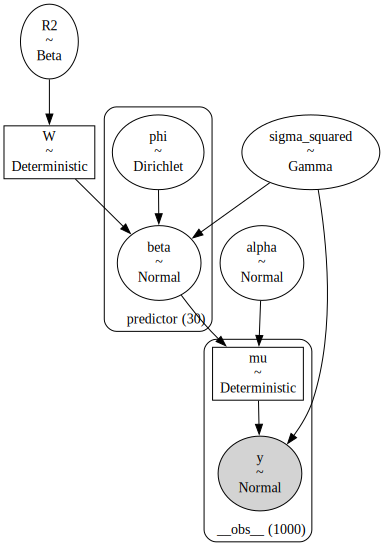

In [6]:
coords = {
    "predictor": np.arange(p),
    "__obs__": np.arange(n)
}

with pm.Model(coords=coords) as model_r2d2:
    R2 = pm.Beta("R2", alpha=2, beta=2)
    phi = pm.Dirichlet("phi", a=np.ones(p), dims="predictor")
    W = pm.Deterministic("W", R2 / (1 - R2))

    sigma_squared = pm.Gamma("sigma_squared", mu=9, sigma=3) # Informative
    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta", mu=0, sigma=(phi * W * sigma_squared) ** 0.5, dims="predictor")
    mu = pm.Deterministic("mu", alpha + (X_std @ beta), dims="__obs__")

    pm.Normal("y", mu=mu, sigma=sigma_squared ** 0.5, observed=y, dims="__obs__")

model_r2d2.to_graphviz()

In [7]:
with model_r2d2:
    idata_r2d2 = pm.sample(random_seed=121195, target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
/home/tomas/miniconda3/envs/pymc-env/lib/python3.13/site-packages/pytensor/link/c/cmodule.py:3004: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R2, phi, sigma_squared, alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


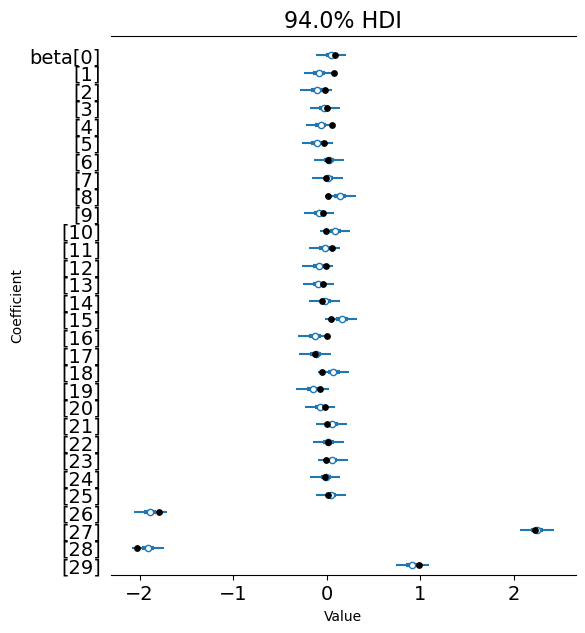

In [10]:
ax = az.plot_forest(idata_r2d2, var_names="beta", combined=True)[0]
ax.scatter(TRUE_BETAS, ax.get_yticks()[::-1], color="black", s=15, zorder=10)
ax.set(xlabel="Value", ylabel="Coefficient");

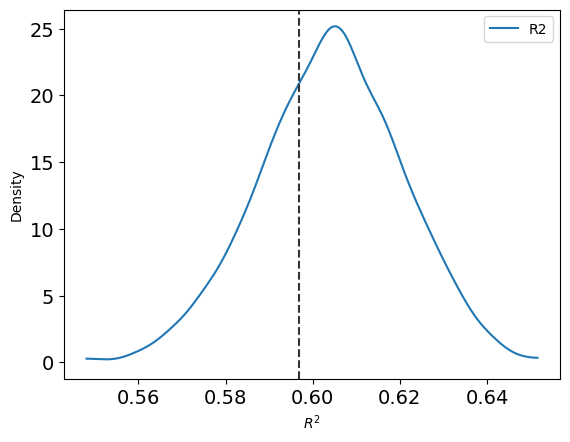

In [9]:
ax = az.plot_dist(compute_R2(idata_r2d2.posterior["mu"], idata_r2d2.posterior["sigma_squared"]), label="R2")
ax.axvline(TRUE_R2, color="0.2", ls="--")
ax.set(xlabel="$R^2$", ylabel="Density");

## R2D2 for GLMMs

$$
\begin{aligned}
Y_i \mid \mu_i, \theta &\underset{iid}{\sim} \text{Distribution}(\mu_i, \theta) \\
g(\mu_i) = \eta_i &= \alpha + \boldsymbol{x}_i \boldsymbol{\beta} + \sum_{k=1}^{q}u_{k g_k[i]} \\
\end{aligned}
$$

* There are $n$ observations, indexed with $i \in \{1, \dots, n\}$.
* The response for the $i$-th observation is $Y_i$.
* The mean of the response for the $i$-th observation is $\mu_i$.
* Given the mean $\mu_i$, and possibly other parameters $\theta$, the $Y_i$ are independent and identically distributed.
* The link function is $g(\cdot)$.
* The linear predictor for the $i$-th observation is $\eta_i$.
* There is an intercept term $\alpha$.
* There are $p$ explanatory variables:
    * The vector of explanatory variables for observation $i$-th is $\boldsymbol{x}_i = (x_{i1}, x_{i2}, \dots, x_{ip})$.
    * The vector of fixed effects is $\boldsymbol{\beta} = (\beta_1, \dots, \beta_p)^T$.
    * The variables are standardized such that each column of the design matrix $\boldsymbol{X}$, of shape $n \times p$, has mean zero and variance one.
* There are $q$ types of random effects.
    * The $k$-th type has $L_k$ levels $\boldsymbol{u}_k = (u_{k1}, u_{k2}, \dots, u_{kL_k})^T$.
    * We use $g_k[i]$ indicate the level of the random effect $k$ for the observation $i$.

To construct the R2D2 prior for GLLMs, we use the following prior model:

$$
\begin{aligned}
\beta_j \mid \phi_j, W &\sim \text{Normal}(0, \phi_j W) \\
\boldsymbol{u}_k \mid \phi_{p + k}, W &\sim \text{Normal}(0, \phi_{p + k}W \boldsymbol{I}_{L_k})
\end{aligned}
$$

where we have that:

* The parameter $W$ controls the overall variance of the linear predictor.
    * It's the total amount of variation in the fixed and random effects.
    * Larger values represent a more flexible model.
    * Smaller values represent a model that is closer to the intercept-only model.
* The parameters $\phi_j \ge 0$, which satisfy $\sum_{j=1}^{p+q} \phi_j = 1$,
determine how the total variance is allocated across the different model components.

Usually, the variance parameters $\boldsymbol{\phi} = (\phi_1, \dots, \phi_{p + q})$ are assigned a Dirichlet prior:

$$
\boldsymbol{\phi} \sim \text{Dirichlet}(\xi_1, \dots, \xi_{p+q})
$$

In many applications, all concentration parameters ($\xi_j$) are set to a common value ($\xi_0$).
Larger values of $\xi_0$ shrink all the variance components toward $1 / (p + q)$,
while smaller values allow for greater uncertainty and more dispersed allocations.

The authors of the R2D2 GLMM paper use a marginal $R^2$ that averages over explanatory variables and random effects ($\boldsymbol{X}$ and $\boldsymbol{g}$) as well as parameters ($\boldsymbol{\beta}$ and $\boldsymbol{u}_k$). The formula for $R^2$ is:

$$
R^2 = \frac{\mathbb{V}(\mu(\eta))}{\mathbb{V}(\mu(\eta)) + \mathbb{E}(\sigma^2(\eta))}
$$

where

$$
\begin{aligned}
\mathbb{E}(Y \mid \eta) &= \mu(\eta) \\
\mathbb{V}(Y \mid \eta) &= \sigma^2(\eta)
\end{aligned}
$$

are summaries of the distribution of $\eta$ and thus depend on parameters $\alpha$ and $W$ (so does $R^2$).

The details can be found in the paper.

The essence is that we need a joint prior on $(\alpha, W)$ such that the induced prior on $R^2$ is $\text{Beta}(a, b)$.

They construct such prior by placing a prior for $W \mid \alpha$ and another prior for $\alpha$.

They notice that, since $R^2 \sim \text{Beta}(a, b)$ conditioned on any $\alpha$,
$R^2$ also follows a $\text{Beta}(a, b)$ distribution marginally over the join prior for $(\alpha, W)$
for any marginal prior on $\alpha$.
Combined with the Dirichlet prior on the variance proportions $\boldsymbol{\phi}$, this results in the R2D2 prior for GLMMs.

While the prior on $W$ can be found in closed form for some model families, the authors suggest to use the same approximate method for all families.

Such method consists of placing a Generalized Beta Prime (GBP) distribution on
$W$ such that the induced prior on $R^2$ is approximately Beta$(a, b)$.

The problem is to find the values of $(a^*, b^*, c^*, d^*)$ so that the prior $W \sim \text{GBP}(a^*, b^*, c^*, d^*)$ induces a prior on $R^2$ that is close to $\text{Beta}(a, b)$.

The optimal values of $(a^*, b^*, c^*, d^*)$ depend on $\mu(\cdot)$ and $\sigma^2(\cdot)$ as well as on $\alpha$, $a$, and $b$.
For given link functions and parameters, let $W \sim p(w)$ be the distribution that gives exactly $R^2 \sim \text{Beta}(a, b)$.

The GBP parameters are found by minimizing the Pearson $\chi^2$ divergence between the true and approximated PDFs,
incorporating a regularization term to shrink the result towards a $\text{GBP}(a, b, 1, 1)$ distribution, which is the exact solution in some special cases and can be considered the baseline.

The optimization problem is then:

$$
\begin{aligned}
(a^*, b^*, c^*, d^*)
& =
    \arg\min_{\alpha, \beta, c, d} \left[
        \int_0^{\infty}
        \left\{
            \frac{f_{GBP}(w, \alpha, \beta, c, d) - p(w)}{p(w)}
        \right\}^2
        p(w) dw + \lambda
    \left[
        (\alpha - a)^2 + (\beta - b)^2 + (c - 1)^2 + (d - 1)^2
    \right]
\right]
\end{aligned}
$$

In there, $\lambda \ge 0$ is a tuning parameter that controls the strength of the regularization. The authors suggest to use $\lambda = \frac{1}{4}$.

In practice, to specify the R2D2 prior for GLMMs, the user needs to provide the parameters $a$ and $b$ of the desired Beta prior on $R^2$.
Then, we solve the optimization problem above to find the parameters $(a^*, b^*, c^*, d^*)$ of the GBP prior on $W$.
Finally, we use the following relationship to set that prior on $W$

$$
V \sim \text{Beta}(a^*, b^*) \implies W = d^*\left[\frac{V}{1 - V}\right]^{1/c^*} \sim \text{GBP}(a^*, b^*, c^*, d^*)
$$




---

I think the end message is that we put a prior on a marginal $R^2$, but then, a posteriori, we look at a conditional $R^2$ (the one from Gelman et al).